In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

Fish dataset consists of photos in .png format located within folders. Therefore, unlike in typical ML applications, we cannot read it with pd.read_csv. We need to preprocess this data and create a Pandas DataFrame beforehand.

In [2]:
label = []
path = []
fishes_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, file_names in os.walk(fishes_dir):
    for file_name in file_names:
        if os.path.splitext(file_name)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, file_name))
                
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

# Inspecting the Dataset
Pandas library is used to inspect the dataset. Here, initially the size of the dataset, then a few rows of dataset and then the distribution of the labels in dataset are inspected.

In [3]:
print(data.shape)
print(data.head())
print(data['label'].value_counts())

(9000, 2)
                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


# Visualization

The first 5 photo data are visualized to inpect the data better.

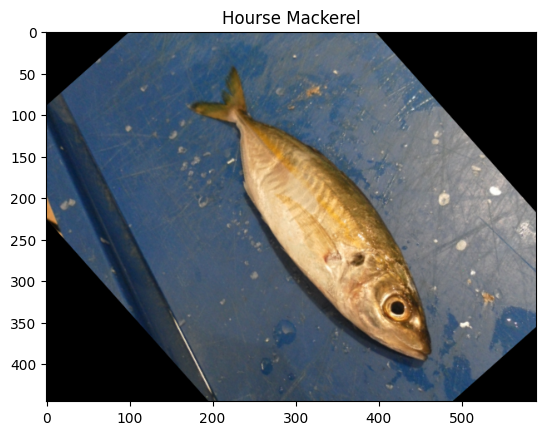

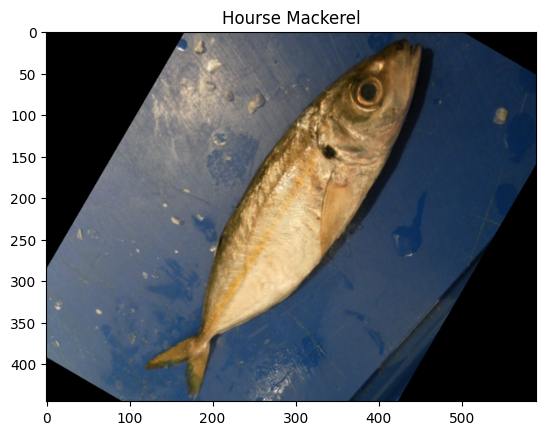

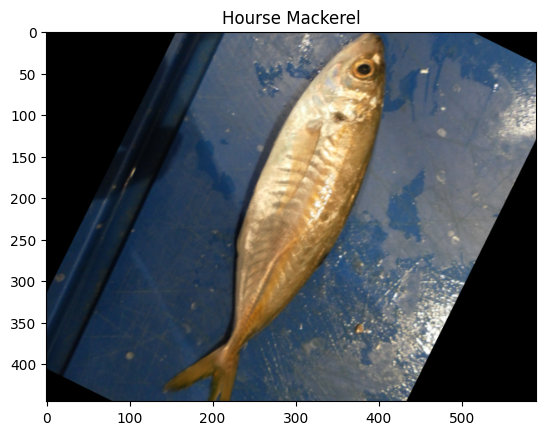

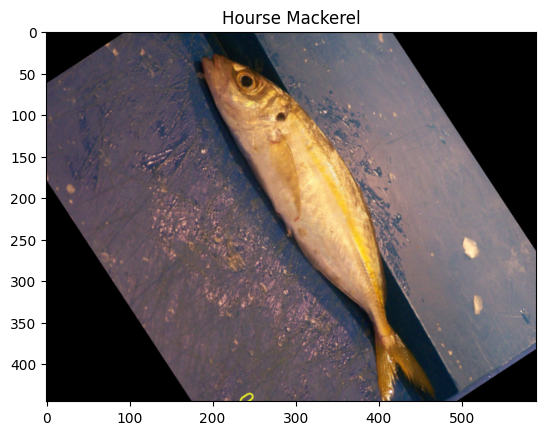

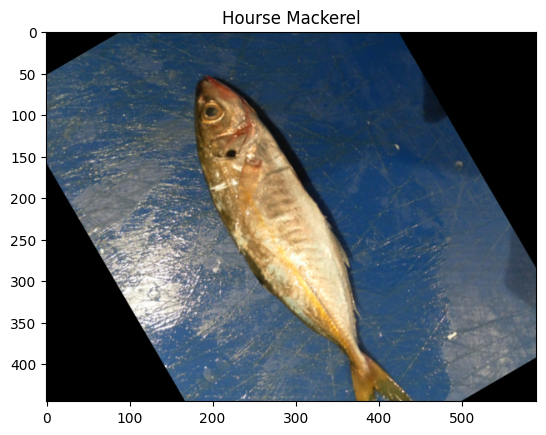

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

for i in range(5):
    img = Image.open(data['path'][i])
    plt.imshow(img)
    plt.title(data['label'][i])
    plt.show()

# Preparing the Data for Training
Preparing the data by splitting the dataset as 80% training and 20% test

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training set size: {train_data.shape}")
print(f"Test set size: {test_data.shape}")


Training set size: (7200, 2)
Test set size: (1800, 2)


# Data Preprocessing and Preparation of Images
At this part, we need to resize and normalize the images. We can perform data augmentation and normalization using an ImageDataGenerator.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)  

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 7200 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


# Training the Model using ANN
We will create an artificial neural network (ANN) model. Here we can determine the number of layers, activation functions and dropout layers of the model.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(150, 150, 3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax')) 

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 213s 916ms/step - accuracy: 0.1097 - loss: 5.2127 - val_accuracy: 0.1083 - val_loss: 2.1974
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 665ms/step - accuracy: 0.1189 - loss: 2.1973 - val_accuracy: 0.0994 - val_loss: 2.1975
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 154s 666ms/step - accuracy: 0.1037 - loss: 2.1975 - val_accuracy: 0.0994 - val_loss: 2.1976
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 665ms/step - accuracy: 0.1117 - loss: 2.1973 - val_accuracy: 0.0994 - val_loss: 2.1977
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 665ms/step - accuracy: 0.1078 - loss: 2.1974 - val_accuracy: 0.0994 - val_loss: 2.1978
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 154s 669ms/step - accuracy: 0.1113 - loss: 2.1974 - val_accuracy: 0.0994 - val_loss: 2.1978
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 154s 668ms/step - accuracy: 0.1179 - loss: 2.1971 - val_accuracy: 0.0994 - val_loss: 2.1978
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 665ms/step - accuracy: 0.1117 - loss: 2.19

# Evaluating the Model
We can plot graphs to monitor the accuracy and loss of the model

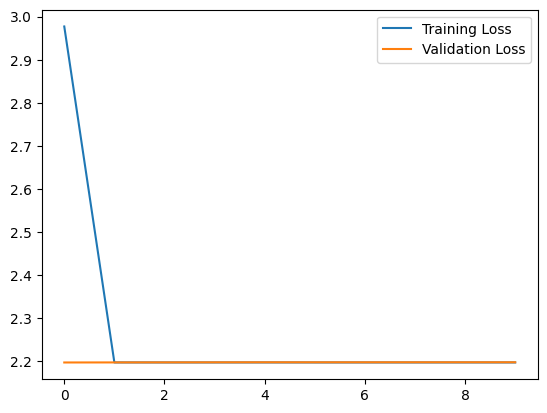

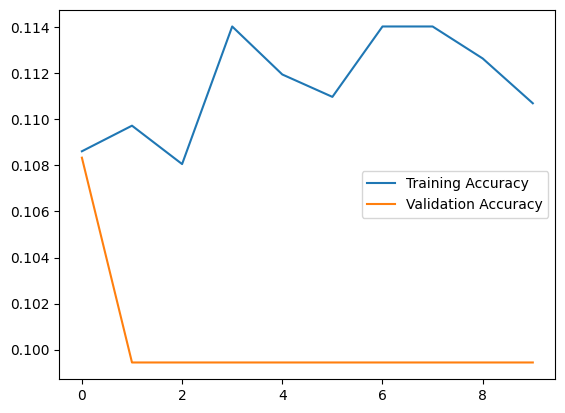

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

print(classification_report(y_true, y_pred))


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step
[[  0   0   0   0   0 211   0   0   0]
 [  0   0   0   0   0 204   0   0   0]
 [  0   0   0   0   0 195   0   0   0]
 [  0   0   0   0   0 191   0   0   0]
 [  0   0   0   0   0 201   0   0   0]
 [  0   0   0   0   0 179   0   0   0]
 [  0   0   0   0   0 209   0   0   0]
 [  0   0   0   0   0 207   0   0   0]
 [  0   0   0   0   0 203   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       211
           1       0.00      0.00      0.00       204
           2       0.00      0.00      0.00       195
           3       0.00      0.00      0.00       191
           4       0.00      0.00      0.00       201
           5       0.10      1.00      0.18       179
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       207
           8       0.00      0.00      0.00       203

    accuracy                           0.10      1800
   macro a

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Hyperparameter Optimization
To adjust the model's hyperparameters, we can try different combinations of values such as the number of layers, the number of nodes, and the dropout rate.

In [10]:
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))